In [16]:
%load_ext autoreload
%autoreload 2

import pydrake
import torch
import pyro
from pyro import poutine
import time
import matplotlib.pyplot as plt

import scene_generation.data.dataset_utils as dataset_utils

from scene_generation.models.planar_multi_object_multi_class_2 import MultiObjectMultiClassModel

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
import numpy as np
DATA_DIR_TRAIN = "/home/gizatt/projects/scene_generation/data/planar_tabletop/planar_tabletop_unstructured_scenes_train/"
DATA_DIR_TEST = "/home/gizatt/projects/scene_generation/data/planar_tabletop/planar_tabletop_unstructured_scenes_train/"
#DATA_FILE = "/home/gizatt/projects/scene_generation/data/planar_bin/planar_bin_static_scenes.yaml"
scenes_dataset_yaml = dataset_utils.ScenesDataset(DATA_DIR_TRAIN)
params_by_object_class = {}
for env_i in range(len(scenes_dataset_yaml)):
    env = scenes_dataset_yaml[env_i]
    for obj_i in range(env["n_objects"]):
        obj_yaml = env["obj_%04d" % obj_i]
        class_name = obj_yaml["class"]
        if class_name not in params_by_object_class.keys():
            params_by_object_class[class_name] = []
        params_by_object_class[class_name].append(obj_yaml["pose"] + obj_yaml["params"])

for object_name in params_by_object_class.keys():
    print object_name, ": "
    params = np.stack(params_by_object_class[object_name])
    print params.shape
    print "means: ", np.mean(params, axis=0)
    print "vars: ", np.std(params, axis=0)

2d_box : 
(6040, 5)
means:  [3.90752733e-04 1.03425954e-03 3.11805768e+00 2.00945021e-01
 1.99953288e-01]
vars:  [0.22458155 0.22068908 1.80283916 0.05749996 0.05769929]
2d_sphere : 
(6089, 4)
means:  [-4.50190634e-04 -1.14910612e-03  3.15168010e+00  1.00058007e-01]
vars:  [0.21133226 0.21221551 1.82903427 0.02908806]


1491


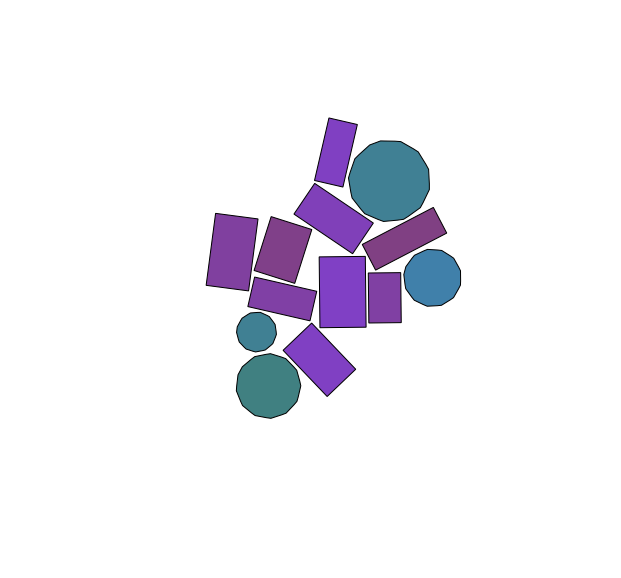

In [18]:
print len(scenes_dataset_yaml)

side_width = 1

plt.figure().set_size_inches(10, 10)
for k in range(side_width):
    for l in range(side_width):
        plt.subplot(side_width, side_width, k*side_width+l+1)
        scene = scenes_dataset_yaml[k*side_width+l+1]
        dataset_utils.DrawYamlEnvironmentPlanar(scene, "planar_tabletop", ax=plt.gca())
        x = np.vstack(scene["obj_%04d" % k]["pose"][0:2] for k in range(scene["n_objects"]))
        plt.gca().set_title("")

Train # batches:  1491
Test # batches:  1491


(0.0, 0.2)

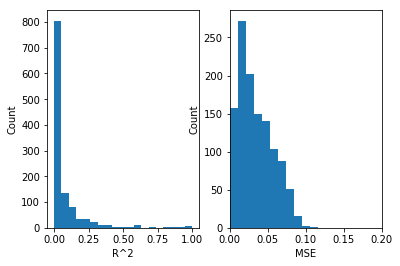

In [25]:
scenes_dataset = dataset_utils.ScenesDatasetVectorized(DATA_DIR_TRAIN, "planar_tabletop", max_num_objects=20)
data = scenes_dataset.get_full_dataset()

scenes_dataset_test = dataset_utils.ScenesDatasetVectorized(DATA_DIR_TEST, "planar_tabletop", max_num_objects=20)
data_test = scenes_dataset_test.get_full_dataset()

print "Train # batches: ", data.batch_size
print "Test # batches: ", data_test.batch_size

# Measure colinearity by doing a linear fit and reporting the error
import scipy.stats
rsquares = []
mses = []
for scene in data_test.convert_to_yaml():
    if (scene["n_objects"] > 2):
        x = np.vstack(scene["obj_%04d" % k]["pose"][0:2] for k in range(scene["n_objects"]))
        slope, intercept, rvalue, pvalue, stderr = scipy.stats.linregress(x[:, 0], x[:, 1])
        rsquares.append(rvalue**2.)
        mses.append(np.mean(np.square(x[:, 1] - (intercept + slope*x[:, 0]))))
plt.figure()
plt.subplot(1, 2, 1)
plt.hist(rsquares, bins=np.linspace(0.0, 1.0, 20))
plt.ylabel("Count")
plt.xlabel("R^2")
plt.subplot(1, 2, 2)
plt.hist(mses, bins=np.linspace(0.0, 0.2, 20))
plt.ylabel("Count")
plt.xlabel("MSE")
plt.xlim(0.0, 0.2)

In [5]:
# Rig for SVI, running with AutoDelta, which converges fairly reliably but
# confuses the variances
from collections import defaultdict
from torch.distributions import constraints
from pyro.infer import Trace_ELBO, SVI
from pyro.contrib.autoguide import AutoDelta, AutoDiagonalNormal, AutoMultivariateNormal, AutoGuideList
import datetime
from tensorboardX import SummaryWriter

pyro.enable_validation(True)

log_dir = "/home/gizatt/projects/scene_generation/models/runs/pmomc2/planar_tabletop/" + datetime.datetime.now().strftime(
    "%Y-%m-%d-%H-%m-%s")
writer = SummaryWriter(log_dir)
def write_np_array(writer, name, x, i):
    for yi, y in enumerate(x):
        writer.add_scalar(name + "/%d" % yi, y, i)
        
print "All params: ", pyro.get_param_store().get_all_param_names()
interesting_params = ["keep_going_weights",
                      "new_class_weights",
                      "params_means_0", "params_means_1",
                      "params_vars_0", "params_vars_1"]
    
model = MultiObjectMultiClassModel(scenes_dataset)
pyro.clear_param_store()
pyro.get_param_store().save("planar_multi_object_multi_class_2_simple_untrained.pyro")
guide = model.guide

optim = pyro.optim.Adam({'lr': 0.1, 'betas': [0.8, 0.99]})
elbo = Trace_ELBO(max_plate_nesting=1)
svi = SVI(model.model, guide, optim, loss=elbo)
losses = []
losses_test = []
snapshots = {}
for i in range(101):
    # Guesses on important things:
    # Big subsamples appear really important -- I had major loss of
    # convergence when using smaller subsample sizes (like ~50).
    # Also important: prior on the variance must be REALLY low.
    # Otherwise long_box_mean diverges to negative... :(
    # I think there's a fundamental problem with variance estimation
    # under this guide / with this system -- see the single-box-dataset
    # estimates that don't capture the x vs y variance.
    loss = svi.step(data, subsample_size=250) / data.batch_size
    losses.append(loss)
    writer.add_scalar('loss', loss, i)
    
    loss_test = svi.evaluate_loss(data_test, subsample_size=25) / data_test.batch_size
    losses_test.append(loss_test)
    writer.add_scalar('loss_test', loss_test, i)

    for p in pyro.get_param_store().keys():
        if p not in snapshots.keys():
            snapshots[p] = []
        snapshots[p].append(pyro.param(p).cpu().detach().numpy().copy())
    for p in interesting_params:
        write_np_array(writer, p, snapshots[p][-1], i)
    if (i % 10 == 0):
        print ".",
    if (i % 50 == 0):
        print "\n"
        for p in interesting_params:
            print p, ": ", pyro.param(p).detach().numpy()
print "Done"

 All params:  ['keep_going_weights', 'context_updater_module$$$weight_hh_l0', 'new_class_weights', 'context_updater_module$$$bias_hh_l0', 'class_encoder_module_1$$$4.bias', 'params_vars_1', 'params_vars_0', 'context_updater_module$$$weight_ih_l0', 'class_encoder_module_0$$$2.weight', 'class_encoder_module_1$$$4.weight', 'class_encoder_module_0$$$4.weight', 'context_updater_module$$$bias_ih_l0', 'class_encoder_module_0$$$0.weight', 'class_encoder_module_0$$$4.bias', 'class_encoder_module_0$$$0.bias', 'class_encoder_module_1$$$0.weight', 'class_encoder_module_1$$$2.weight', 'params_means_0', 'params_means_1', 'class_encoder_module_1$$$2.bias', 'class_encoder_module_0$$$2.bias', 'class_encoder_module_1$$$0.bias']
. 

keep_going_weights :  [0.5249792]
new_class_weights :  [0.54983395 0.450166  ]
params_means_0 :  [-0.09999999  0.09999999  0.1         0.1         0.1       ]
params_means_1 :  [-0.10000001 -0.10000002  0.10000001  0.1       ]
params_vars_0 :  [0.9048374 0.9048374 1.105171  0

Text(0.5,1,'Loses: final [3.227425 train][2.910166 test]')

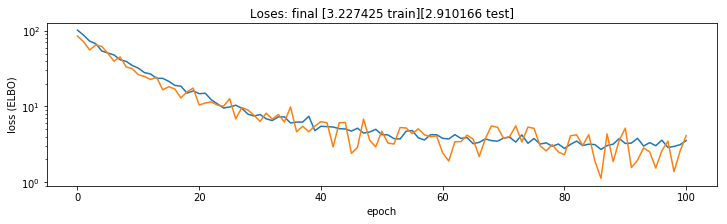

In [6]:
plt.figure().set_size_inches(12, 3)
plt.plot(losses, label="train")
plt.plot(losses_test, label="test")
plt.semilogy()
plt.xlabel("epoch")
plt.ylabel("loss (ELBO)")
plt.title("Loses: final [%f train][%f test]" % (np.mean(losses[-20:]), np.mean(losses_test[-20:])))

In [7]:
# Save model
pyro.get_param_store().save("planar_multi_object_multi_class_2_simple_unstructured.pyro")

In [9]:
# Load model
pyro.clear_param_store()
pyro.get_param_store().load("planar_multi_object_multi_class_2_simple_unstructured.pyro")
model = MultiObjectMultiClassModel(scenes_dataset)

In [22]:
# Convert that data back to a YAML environment, which is easier to
# handle.
for i in range(1):
    scene_with_most_objects = None
    for k in range(1):
        generated_data, generated_encodings, generated_contexts = model.model()
        scene_yaml = scenes_dataset.convert_vectorized_environment_to_yaml(
            generated_data)
        if scene_with_most_objects is None or scene_yaml[0]["n_objects"] > scene_with_most_objects["n_objects"]:
            scene_with_most_objects = scene_yaml[0]

    print scene_with_most_objects
    dataset_utils.DrawYamlEnvironment(scene_with_most_objects, "planar_tabletop")
    time.sleep(1.0)

{'obj_0000': {'color': [0.5629112209189979, 0.0, 1.0, 1.0], 'pose': [-0.06040780246257782, 0.05532841756939888, -0.6843569278717041], 'params': [0.053256429731845856], 'class': '2d_sphere', 'params_names': ['radius']}, 'obj_0001': {'color': [0.6206560362733398, 0.0, 1.0, 1.0], 'pose': [-0.26056522130966187, -0.02563430368900299, 4.96314811706543], 'params': [0.24138551950454712, 0.27296194434165955], 'class': '2d_box', 'params_names': ['height', 'length']}, 'n_objects': 2}
Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6000...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/
Connected to meshcat-server.


[1, 2, 20, 5, 2, 4, 11, 7, 1, 6, 9, 20, 11, 7, 20, 1, 1, 13, 13, 1, 2, 10, 2, 15, 6, 3, 3, 8, 2, 20, 1, 12, 2, 8, 7, 4, 20, 4, 13, 2, 4, 8, 1, 17, 1, 13, 18, 18, 3, 20, 4, 1, 9, 12, 3, 20, 14, 5, 10, 17, 8, 12, 11, 9, 4, 16, 2, 5, 2, 5, 15, 2, 2, 1, 8, 9, 5, 4, 3, 1, 2, 8, 4, 2, 8, 1, 5, 3, 1, 20, 9, 6, 1, 1, 10, 4, 2, 7, 2, 1, 2, 16, 8, 4, 7, 4, 9, 20, 1, 16, 10, 20, 20, 16, 14, 4, 9, 8, 1, 11, 1, 6, 2, 17, 12, 6, 6, 9, 13, 5, 4, 2, 5, 9, 6, 9, 3, 8, 10, 15, 19, 3, 3, 6, 19, 13, 4, 20, 2, 11, 3, 11, 2, 18, 18, 8, 10, 2, 5, 4, 20, 1, 9, 20, 17, 2, 1, 11, 12, 3, 9, 12, 9, 3, 2, 5, 20, 6, 5, 7, 19, 1, 8, 20, 20, 1, 4, 19, 1, 10, 6, 2, 2, 6, 7, 4, 7, 5, 4, 11]


(array([ 0., 24., 25., 12., 18., 12., 11.,  8., 12., 13.,  7.,  8.,  6.,
         6.,  2.,  3.,  4.,  4.,  8.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 <a list of 19 Patch objects>)

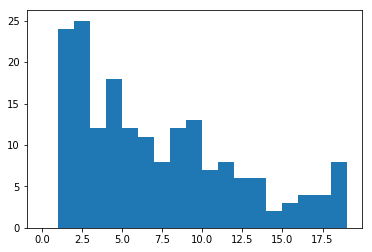

In [23]:
# Convert that data back to a YAML environment, which is easier to
# handle.
generated_n_objs = []
for i in range(200):
    generated_data, generated_encodings, generated_contexts = model.model()
    scene_yaml = scenes_dataset.convert_vectorized_environment_to_yaml(
            generated_data)
    generated_n_objs.append(scene_yaml[0]["n_objects"])
print generated_n_objs
plt.hist(generated_n_objs, bins=range(20))

2d_box::x: -0.01 +/- 0.23
2d_box::z: 0.01 +/- 0.22
2d_box::theta: 3.10 +/- 1.80
2d_box::height: 0.21 +/- 0.06
2d_box::length: 0.21 +/- 0.06
2d_sphere::x: 0.01 +/- 0.21
2d_sphere::z: 0.00 +/- 0.21
2d_sphere::theta: 3.10 +/- 1.82
2d_sphere::radius: 0.10 +/- 0.03


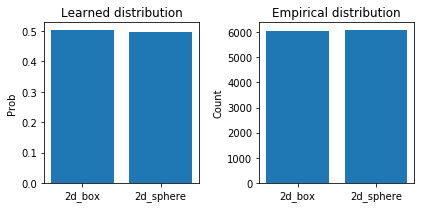

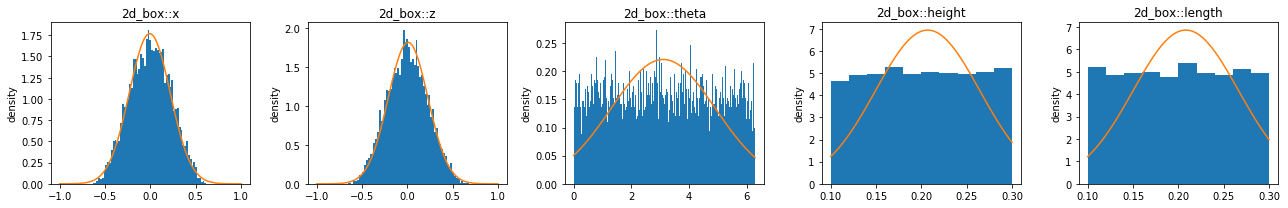

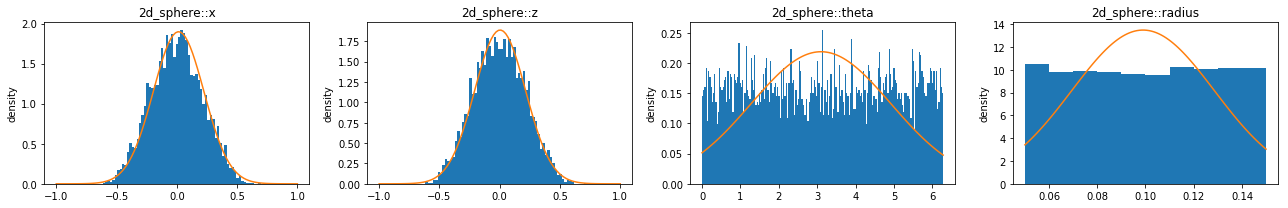

In [26]:
import matplotlib.pyplot as plt
from scipy.stats import norm


class_weight_vals = pyro.param("new_class_weights").detach().numpy().copy()

# Use params_by_object_class from when we loaded dataset.
plt.figure().set_size_inches(6, 3)
plt.subplot(1, 2, 1)
plt.title("Learned distribution")
plt.bar([0, 1], class_weight_vals)
plt.xticks([0, 1], scenes_dataset.class_id_to_name)
plt.ylabel("Prob")
plt.subplot(1, 2, 2)
plt.title("Empirical distribution")
plt.bar([0, 1], [len(params_by_object_class[object_name]) for object_name in scenes_dataset.class_id_to_name])
plt.xticks([0, 1], scenes_dataset.class_id_to_name)
plt.ylabel("Count")
plt.tight_layout()


for object_name in params_by_object_class.keys():
    object_id = scenes_dataset.class_name_to_id[object_name]
    params_means = pyro.param("params_means_%d" % object_id).detach().numpy()
    params_vars = pyro.param("params_vars_%d" % object_id).detach().numpy()
    plt.figure().set_size_inches(18, 3)
    params = np.stack(params_by_object_class[object_name]).copy()
    #params[2, :] = (params[2, :] + 2 * np.pi) % (2 * np.pi)
    for k in range(params.shape[1]):
        if k >= 3:
            param_name = scenes_dataset.params_names_by_class[object_id][k - 3]
        else:
            param_name = ["x", "z", "theta"][k]
        print(object_name + "::" + param_name + ": %2.2f +/- %2.2f" % (params_means[k], params_vars[k]))
        plt.subplot(1, params.shape[1], k+1)
        plt.title(object_name + "::" + param_name)
        plt.ylabel("density")
        bins = None
        if k == 0:
            bins = np.linspace(-1., 1., 100)
        elif k == 1:
            bins = np.linspace(-1., 1., 100)
        elif k == 2:
            bins = np.linspace(0, 2*np.pi, 200)
        x_bins = plt.hist(params[:, k], label="Empirical", density=True, bins=bins)[1]
        x_range = np.linspace(x_bins[0], x_bins[-1], 100)
        plt.plot(x_range, norm.pdf(x_range, params_means[k], params_vars[k]), label="Learned")
        
    plt.tight_layout()
    

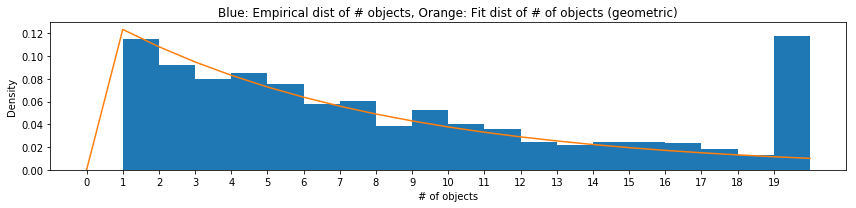

In [25]:
import scipy as sp
import scipy.stats
# Draw the keep_going CDF, which is the product of all previous keep_going vals.
keep_going_vals = pyro.param("keep_going_weights").detach().numpy().copy()
keep_going_pdf = np.zeros(keep_going_vals.shape[0])
for k in range(0, keep_going_pdf.shape[0]):
    keep_going_pdf[k] = np.prod(keep_going_vals[0:k])*(1. - keep_going_vals[k])
plt.figure().set_size_inches(12, 3)
plt.title("Blue: Empirical dist of # objects, Orange: Fit dist of # of objects (geometric)")
plt.xlabel("# of objects")
plt.ylabel("Density")
xbins = plt.hist([p["n_objects"] for p in scenes_dataset_yaml], bins=range(0, 21), density=True)[1]
plt.plot(xbins, sp.stats.geom.pmf(xbins, 1.-keep_going_vals[0]))
plt.xticks(range(20))
plt.tight_layout()

In [ ]:
# Assume projection has been done for this trained model and saved to these files...

def generate_params_by_object_class(scenes_dataset_yaml):
    params_by_object_class = {}
    for env_i in range(len(scenes_dataset_yaml)):
        env = scenes_dataset_yaml[env_i]
        for obj_i in range(env["n_objects"]):
            obj_yaml = env["obj_%04d" % obj_i]
            class_name = obj_yaml["class"]
            if class_name not in params_by_object_class.keys():
                params_by_object_class[class_name] = []
            params_by_object_class[class_name].append(obj_yaml["pose"] + obj_yaml["params"])
    return params_by_object_class  

scenes_dataset_yaml_static = dataset_utils.ScenesDataset(
    "/home/gizatt/projects/scene_generation/models/generated_planar_bin_static_scenes_geometric_static.yaml")
params_by_object_class_static = generate_params_by_object_class(scenes_dataset_yaml_static)

scenes_dataset_yaml_nonpen = dataset_utils.ScenesDataset(
    "/home/gizatt/projects/scene_generation/models/generated_planar_bin_static_scenes_geometric_nonpen.yaml")
params_by_object_class_nonpen = generate_params_by_object_class(scenes_dataset_yaml_nonpen)

In [ ]:
for object_name in params_by_object_class.keys():
    object_id = scenes_dataset.class_name_to_id[object_name]
    plt.figure().set_size_inches(18, 3)
    
    param_sets_base = [
        params_by_object_class[object_name],
        #params_by_object_class_nonpen[object_name],
        params_by_object_class_static[object_name]
    ]
    #params_sets_names = ["empirical", "nonpenetrating", "static"]
    params_sets_names = ["empirical", "static"]
    
    param_sets = []
    for params in param_sets_base:
        params_stacked = np.stack(params).copy()
        #params_stacked[2, :] = (params_stacked[2, :] + 2 * np.pi) % (2 * np.pi)
        param_sets.append(params_stacked)

    for k in range(param_sets[0].shape[1]):
        if k >= 3:
            param_name = scenes_dataset.params_names_by_class[object_id][k - 3]
        else:
            param_name = ["x", "z", "theta"][k]
        plt.subplot(1, param_sets[0].shape[1], k+1)
        plt.title(object_name + "::" + param_name)
        plt.ylabel("density")
        bins = None
        if k == 0:
            bins = np.linspace(-1., 1., 100)
        elif k == 1:
            bins = np.linspace(0., 1., 100)
        elif k == 2:
            bins = np.linspace(0, 2*np.pi, 200)
        for i, params in enumerate(param_sets):
            x_bins = plt.hist(params[:, k], label=params_sets_names[i], density=True, bins=bins, alpha=0.5)[1]
        x_range = np.linspace(x_bins[0], x_bins[-1], 100)
        plt.legend()
        
    plt.tight_layout()
    